In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

import json
import urllib2

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#OTP_SERVER_URL = 'http://150.165.85.4:10402/otp/'
OTP_SERVER_URL = 'http://localhost:5601/otp/'

def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_hdfs_folder(sqlContext, folderpath):
    data_frame = sqlContext.read.csv(folderpath, header=True,
                                     inferSchema=True,nullValue="-")
    return data_frame

def read_buste_data_v3(sqlContext, folderpath):
    data_frame = read_hdfs_folder(sqlContext,folderpath)
    
    date = "-".join(folderpath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    #data_frame = data_frame.withColumn("date", F.unix_timestamp(F.col("date"),1),'yyyy-MM-dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

def get_timestamp_in_tz(unixtime_timestamp,ts_format,tz):
    return F.from_utc_timestamp(F.from_unixtime(unixtime_timestamp, ts_format),tz)

In [3]:
spark  = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.crossJoin.enabled', 'true')

sc = spark.sparkContext
sqlContext = pyspark.SQLContext(sc)

### Reading Data

In [4]:
base_folder_path = '/local/tarciso/masters/data/bus_trips/buste-v3a/06_18-24_2017/'
#base_folder_path = '/local/tarciso/data/trips-optimality-exp/06_18-24_2017/'
date_to_be_analized = F.unix_timestamp(F.lit('2017-06-18'),'yyyy-MM-dd')
od_matrix = read_hdfs_folder(sqlContext,base_folder_path + 'filtered_od/')

In [5]:
od_matrix.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- o_route: integer (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: integer (nullable = true)
 |-- o_trip

In [11]:
printdf(od_matrix.select(['date','route','o_stop_id','o_timestamp','stopPointId','timestamp','o_boarding_id']))

,date,route,o_stop_id,o_timestamp,stopPointId,timestamp,o_boarding_id
0,1497668400,393,35438,12:28:00,34221,13:20:04,17179869192
1,1497668400,655,36208,14:14:51,38509,14:14:54,1683627180038
2,1497668400,658,35536,14:28:29,38498,14:28:50,1589137899525
3,1497668400,924,36660,18:59:21,27340,19:13:40,438086664200
4,1497668400,625,36078,06:54:02,25639,07:04:25,85899345929
5,1497668400,825,34633,17:25:38,36478,17:56:45,240518168587
6,1497668400,272,30775,18:55:27,32320,20:26:10,1554778161167
7,1497668400,673,32163,19:23:06,32173,21:53:41,824633720840
8,1497668400,761,32402,09:08:55,32847,10:13:41,850403524628
9,1497668400,711,35430,17:16:39,8871,17:20:01,1262720385057


In [12]:
od_matrix.count()

24911

### Filtering Data

In [13]:
od_matrix = od_matrix.filter(od_matrix.date == date_to_be_analized)

In [16]:
od_matrix.count()

674

#### Advancing start time by two minutes to correct for any GPS precision problems when starting at a bus stop

In [17]:
extra_seconds = 120
od_matrix = od_matrix.withColumn('date_str', F.from_unixtime(F.col('date'), 'yyyy-MM-dd')) \
                        .withColumn('o_datetime', F.concat(F.col('date_str'), F.lit(' '), F.col('o_timestamp'))) \
                        .withColumn('d_datetime', F.concat(F.col('date_str'), F.lit(' '), F.col('timestamp'))) \
                        .withColumn('executed_duration', (F.unix_timestamp('d_datetime') - F.unix_timestamp('o_datetime'))/60) \
                        .withColumn('o_base_datetime', F.from_unixtime(F.unix_timestamp(F.col('o_datetime'),'yyyy-MM-dd HH:mm:ss') - extra_seconds, 'yyyy-MM-dd HH:mm:ss')) \

In [18]:
printdf(od_matrix.select(['date_str','o_timestamp','o_datetime','d_datetime','executed_duration','o_base_datetime']))

,date_str,o_timestamp,o_datetime,d_datetime,executed_duration,o_base_datetime
0,2017-06-18,23:02:22,2017-06-18 23:02:22,2017-06-18 23:28:11,25.816667,2017-06-18 23:00:22
1,2017-06-18,12:26:25,2017-06-18 12:26:25,2017-06-18 12:26:31,0.100000,2017-06-18 12:24:25
2,2017-06-18,14:41:43,2017-06-18 14:41:43,2017-06-18 14:45:29,3.766667,2017-06-18 14:39:43
3,2017-06-18,12:51:11,2017-06-18 12:51:11,2017-06-18 13:27:55,36.733333,2017-06-18 12:49:11
4,2017-06-18,17:24:13,2017-06-18 17:24:13,2017-06-18 19:36:57,132.733333,2017-06-18 17:22:13
5,2017-06-18,08:36:34,2017-06-18 08:36:34,2017-06-18 08:48:09,11.583333,2017-06-18 08:34:34
6,2017-06-18,18:44:32,2017-06-18 18:44:32,2017-06-18 18:47:28,2.933333,2017-06-18 18:42:32
7,2017-06-18,08:26:52,2017-06-18 08:26:52,2017-06-18 08:37:04,10.200000,2017-06-18 08:24:52
8,2017-06-18,19:08:18,2017-06-18 19:08:18,2017-06-18 20:20:42,72.400000,2017-06-18 19:06:18
9,2017-06-18,15:47:44,2017-06-18 15:47:44,2017-06-18 16:56:44,69.000000,2017-06-18 15:45:44


In [19]:
def get_otp_itineraries(o_lat,o_lon,d_lat,d_lon,date,time):
    otp_http_request = 'routers/ctba/plan?fromPlace={},{}&toPlace={},{}&mode=TRANSIT,WALK&date={}&time={}'
    otp_request_url = OTP_SERVER_URL + otp_http_request.format(o_lat,o_lon,d_lat,d_lon,date,time)
    #print otp_request_url
    return json.loads(urllib2.urlopen(otp_request_url).read())

In [20]:
test_itinerary = get_otp_itineraries(-25.413083,-49.229020,-25.428322,-49.266739,'05-10-2017','7:19:00')

print test_itinerary

{u'elevationMetadata': {u'geoidElevation': False, u'ellipsoidToGeoidDifference': 3.686111287840708}, u'plan': {u'date': 1494411540000, u'to': {u'lat': -25.428322, u'vertexType': u'NORMAL', u'lon': -49.266739, u'name': u'Destination', u'orig': u''}, u'itineraries': [{u'walkTime': 2, u'legs': [{u'distance': 0.151, u'from': {u'vertexType': u'NORMAL', u'name': u'Origin', u'lon': -49.22902, u'departure': 1494411566000, u'lat': -25.413083, u'orig': u''}, u'interlineWithPreviousLeg': False, u'transitLeg': False, u'realTime': False, u'route': u'', u'departureDelay': 0, u'agencyTimeZoneOffset': -10800000, u'to': {u'arrival': 1494411567000, u'vertexType': u'TRANSIT', u'name': u'Rua Fagundes Varela, 1295 - Jardim Social', u'stopSequence': 12, u'lon': -49.229029895014, u'departure': 1494411568000, u'stopId': u'1:31957', u'stopCode': u'130279', u'lat': -25.413059468751, u'stopIndex': 11}, u'rentedBike': False, u'arrivalDelay': 0, u'mode': u'WALK', u'startTime': 1494411566000, u'duration': 1.0, u'st

### New Approach

In [21]:
trips_otp_response = {}
counter = 0
for row in od_matrix.collect():
        id=long(row['o_boarding_id'])
        start_time = row['o_base_datetime'].split(' ')[1]
        trip_plan = get_otp_itineraries(row['o_shape_lat'], row['o_shape_lon'], row['shapeLat'], row['shapeLon'],row['date_str'],start_time)
        trips_otp_response[id] = trip_plan
        counter+=1

In [22]:
#max_ctr = 1
trips_plans = []

for trip in trips_otp_response.keys():
    #if max_ctr == 0:
    #    break
    if 'plan' in trips_otp_response[trip]:
        itinerary_id = 1
        for itinerary in trips_otp_response[trip]['plan']['itineraries']:
            date = trips_otp_response[trip]['plan']['date']/1000
            leg_id = 1
            for leg in itinerary['legs']:
                route = leg['route'] if leg['route'] != '' else None
                fromStopId = leg['from']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                toStopId = leg['to']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                start_time = long(leg['startTime'])/1000
                end_time = long(leg['endTime'])/1000
                duration = (end_time - start_time)/60
                trips_plans.append((date,trip,itinerary_id,leg_id,start_time,end_time,leg['mode'],route,fromStopId,toStopId, duration))
                leg_id += 1
            itinerary_id += 1
    #max_ctr -= 1

labels=['date','user_trip_id','itinerary_id','leg_id','otp_start_time','otp_end_time','mode','route','from_stop_id','to_stop_id','otp_duration_mins']
trips_plans_df = sqlContext.createDataFrame(trips_plans, labels) \
                    .withColumn('date',F.from_unixtime(F.col('date'),'yyyy-MM-dd')) \
                    .withColumn('otp_duration_mins',((F.col('otp_end_time') - F.col('otp_start_time'))/60)) \
                    .withColumn('otp_start_time',F.from_unixtime(F.col('otp_start_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                    .withColumn('otp_end_time',F.from_unixtime(F.col('otp_end_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                    .withColumn('route', F.col('route').astype('integer')) \
                    .withColumn('from_stop_id', F.col('from_stop_id').astype('integer')) \
                    .withColumn('to_stop_id', F.col('to_stop_id').astype('integer')) \
                    .orderBy(['date','user_trip_id','itinerary_id','otp_start_time'])

In [23]:
trips_plans_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)
 |-- mode: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_duration_mins: double (nullable = true)



In [24]:
total_num_trips = trips_plans_df.count()
total_num_bus_trips = trips_plans_df.filter('mode == \'BUS\'').count()
print "Total num Legs:", total_num_trips
print "Total num Bus Legs:", total_num_bus_trips, "(", 100*(total_num_bus_trips/float(total_num_trips)), "%)"

Total num Legs: 5485
Total num Bus Legs: 1805 ( 32.9079307201 %)


In [25]:
print trips_plans_df.select(['user_trip_id']).distinct().count()

674


In [26]:
printdf(trips_plans_df,l=100)

,date,user_trip_id,itinerary_id,leg_id,otp_start_time,otp_end_time,mode,route,from_stop_id,to_stop_id,otp_duration_mins
0,2017-06-18,14,1,1,2017-06-19 05:22:59,2017-06-19 05:23:00,WALK,NaN,NaN,NaN,0.016667
1,2017-06-18,14,1,2,2017-06-19 05:23:01,2017-06-19 06:09:00,BUS,50.0,32416.0,31629.0,45.983333
2,2017-06-18,14,1,3,2017-06-19 06:09:01,2017-06-19 06:09:02,WALK,NaN,NaN,NaN,0.016667
3,2017-06-18,14,2,1,2017-06-19 05:43:20,2017-06-19 05:43:21,WALK,NaN,NaN,NaN,0.016667
4,2017-06-18,14,2,2,2017-06-19 05:43:22,2017-06-19 06:35:00,BUS,50.0,32416.0,31629.0,51.633333
5,2017-06-18,14,2,3,2017-06-19 06:35:01,2017-06-19 06:35:02,WALK,NaN,NaN,NaN,0.016667
6,2017-06-18,14,3,1,2017-06-19 05:58:35,2017-06-19 05:58:36,WALK,NaN,NaN,NaN,0.016667
7,2017-06-18,14,3,2,2017-06-19 05:58:37,2017-06-19 06:50:00,BUS,50.0,32416.0,31629.0,51.383333
8,2017-06-18,14,3,3,2017-06-19 06:50:01,2017-06-19 06:50:02,WALK,NaN,NaN,NaN,0.016667
9,2017-06-18,47,1,1,2017-06-19 04:53:56,2017-06-19 04:54:00,WALK,NaN,NaN,NaN,0.066667


In [27]:
trips_plans_df.write.csv(path=base_folder_path+'/trip_plans',header=True, mode='overwrite')

### Read Bus Data

In [33]:
print base_folder_path

/local/tarciso/masters/data/bus_trips/buste-v3a/06_18-24_2017/


In [34]:
bus_trips_data = read_buste_data_v3(sqlContext,base_folder_path + '/buste/per_day/2017_06_18_veiculos/')

In [35]:
bus_trips_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: string (nullable = false)



In [36]:
clean_bus_trips_data = bus_trips_data.select(["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                    .withColumn('route',F.col('route').astype('float')) \
                    .withColumn('date',F.col('date').astype('string')) \
                    .withColumn('timestamp',F.from_unixtime(F.unix_timestamp(F.concat(F.col('date'),F.lit(' '),F.col('timestamp')), 'yyyy-MM-dd HH:mm:ss')))

In [37]:
clean_bus_trips_data.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: float (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- timestamp: string (nullable = true)



In [38]:
printdf(clean_bus_trips_data)

,date,route,busCode,tripNum,stopPointId,timestamp
0,2017-06-18,10.0,BB302,15,33171,2017-06-18 15:24:30
1,2017-06-18,10.0,BB303,9,33163,2017-06-18 10:36:39
2,2017-06-18,10.0,BB303,12,29104,2017-06-18 12:43:52
3,2017-06-18,11.0,BB307,7,32786,2017-06-18 20:31:01
4,2017-06-18,11.0,BB308,7,32762,2017-06-18 09:18:04
5,2017-06-18,11.0,BB308,12,32791,2017-06-18 21:05:45
6,2017-06-18,11.0,BB308,13,32761,2017-06-18 23:17:59
7,2017-06-18,11.0,BB308,16,32789,2017-06-18 16:04:01
8,2017-06-18,11.0,BB308,18,32765,2017-06-18 19:23:35
9,2017-06-18,20.0,BB301,1,32722,2017-06-18 06:34:29


### Finding Real User Trip Beginning Time

In [39]:
trips_plans_df_start = trips_plans_df.withColumn('stopPointId', F.col('from_stop_id'))
trip_plans_start = trips_plans_df_start.join(clean_bus_trips_data, ['date','route','stopPointId'], how='inner') \
                        .na.drop(subset=['timestamp']) \
                        .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_start_time')))) \
                        .drop('otp_duration')

In [40]:
printdf(trip_plans_start.select(['date','route','from_stop_id','tripNum','otp_start_time','timestamp','timediff']) \
                .orderBy(['date','route','from_stop_id','otp_start_time','timediff']))

,date,route,from_stop_id,tripNum,otp_start_time,timestamp,timediff
0,2017-06-18,10,30150,20,2017-06-19 05:44:24,2017-06-18 23:34:23,22201
1,2017-06-18,10,30150,20,2017-06-19 05:44:24,2017-06-18 23:33:35,22249
2,2017-06-18,10,30150,6,2017-06-19 05:44:24,2017-06-18 22:33:55,25829
3,2017-06-18,10,30150,19,2017-06-19 05:44:24,2017-06-18 22:03:44,27640
4,2017-06-18,10,30150,19,2017-06-19 05:44:24,2017-06-18 21:33:46,29438
5,2017-06-18,10,30150,25,2017-06-19 05:44:24,2017-06-18 21:02:19,31325
6,2017-06-18,10,30150,18,2017-06-19 05:44:24,2017-06-18 20:33:38,33046
7,2017-06-18,10,30150,5,2017-06-19 05:44:24,2017-06-18 20:33:23,33061
8,2017-06-18,10,30150,24,2017-06-19 05:44:24,2017-06-18 20:18:19,33965
9,2017-06-18,10,30150,17,2017-06-19 05:44:24,2017-06-18 20:16:42,34062


In [41]:
trip_plans_start.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)
 |-- mode: string (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_duration_mins: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- timediff: long (nullable = true)



In [42]:
printdf(trip_plans_start)

,date,route,stopPointId,user_trip_id,itinerary_id,leg_id,otp_start_time,otp_end_time,mode,from_stop_id,to_stop_id,otp_duration_mins,busCode,tripNum,timestamp,timediff
0,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA270,22,2017-06-18 07:00:36,81007
1,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA270,10,2017-06-18 23:35:24,21319
2,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA276,18,2017-06-18 20:45:44,31499
3,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA270,5,2017-06-18 13:38:50,57113
4,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA270,30,2017-06-18 19:55:41,34502
5,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA270,29,2017-06-18 18:57:48,37975
6,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA270,20,2017-06-18 20:12:57,33466
7,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA276,11,2017-06-18 14:31:48,53935
8,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA276,27,2017-06-18 19:40:24,35419
9,2017-06-18,659,38924,1546188226607,2,2,2017-06-19 05:30:43,2017-06-19 06:00:09,BUS,38924,36205,29.433333,HA276,3,2017-06-18 08:47:53,74570


In [43]:
w = Window.partitionBy(['date','user_trip_id','itinerary_id','route','from_stop_id']).orderBy(['timediff'])
trip_plans_start = trip_plans_start.withColumn('rn', F.row_number().over(w)) \
                    .where(F.col('rn') == 1)

In [44]:
printdf(trip_plans_start.select('route','from_stop_id','otp_start_time','timestamp') \
           .orderBy(['route','from_stop_id','otp_start_time']))

,route,from_stop_id,otp_start_time,timestamp
0,10,30150,2017-06-19 05:44:24,2017-06-18 23:34:23
1,10,33162,2017-06-19 05:47:40,2017-06-18 23:35:24
2,10,33162,2017-06-19 06:09:44,2017-06-18 23:35:24
3,10,33162,2017-06-19 06:27:44,2017-06-18 23:35:24
4,10,33167,2017-06-19 05:55:54,2017-06-18 23:21:30
5,10,33167,2017-06-19 06:19:44,2017-06-18 23:21:30
6,11,32788,2017-06-19 05:53:58,2017-06-18 23:03:04
7,11,32788,2017-06-19 06:16:52,2017-06-18 23:03:04
8,11,32792,2017-06-19 05:58:55,2017-06-18 23:06:18
9,11,32795,2017-06-19 06:01:37,2017-06-18 23:07:57


In [45]:
trip_plans_start = trip_plans_start \
        .select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','otp_start_time','timestamp','to_stop_id','otp_end_time']) \
        .withColumnRenamed('timestamp','from_timestamp')
printdf(trip_plans_start)

,date,user_trip_id,itinerary_id,leg_id,route,busCode,tripNum,from_stop_id,otp_start_time,from_timestamp,to_stop_id,otp_end_time
0,2017-06-18,85899345949,3,2,203,BD143,12,25385,2017-06-19 05:34:44,2017-06-18 23:39:02,25388,2017-06-19 05:40:25
1,2017-06-18,223338299453,2,2,233,BA134,89,34991,2017-06-19 05:26:23,2017-06-18 23:49:08,35111,2017-06-19 05:30:52
2,2017-06-18,438086664246,2,2,658,JA021,38,35886,2017-06-19 05:36:16,2017-06-18 23:31:38,27620,2017-06-19 06:04:00
3,2017-06-18,506806140993,2,3,468,DC293,35,26179,2017-06-19 06:04:00,2017-06-18 23:16:00,31499,2017-06-19 06:06:10
4,2017-06-18,781684047943,2,2,40,GB600,4,34134,2017-06-19 05:30:29,2017-06-18 23:33:18,35462,2017-06-19 05:56:46
5,2017-06-18,910533066800,3,2,646,HA006,33,38530,2017-06-19 04:55:52,2017-06-18 23:38:44,31032,2017-06-19 05:25:00
6,2017-06-18,910533066846,2,2,545,KA600,21,30039,2017-06-19 05:14:00,2017-06-18 23:34:41,33856,2017-06-19 05:57:50
7,2017-06-18,1176821039105,2,2,372,BC320,15,26210,2017-06-19 05:30:00,2017-06-18 23:29:15,29914,2017-06-19 05:55:09
8,2017-06-18,1194000908337,1,2,625,GA163,42,36060,2017-06-19 05:12:29,2017-06-18 23:08:47,35713,2017-06-19 05:27:53
9,2017-06-18,1503238553631,2,2,828,JA010,13,35137,2017-06-19 06:04:10,2017-06-18 23:22:40,35386,2017-06-19 06:12:24


In [46]:
total_trips_start = trip_plans_start.count()

print "Total Num Bus Legs Start Identified in Data:", total_trips_start, "(", 100*(total_trips_start/float(total_num_bus_trips)), "%)"

trip_plans_start.printSchema()

Total Num Bus Legs Start Identified in Data: 1652 ( 91.5235457064 %)
root
 |-- date: string (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- from_timestamp: string (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)



### Finding Real User Trip End Time

In [47]:
bus_trips_data2 = read_buste_data_v3(sqlContext,base_folder_path + '/buste/per_day/2017_06_18_veiculos/')

In [48]:
clean_bus_trips_data2 = bus_trips_data2.select(["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                    .withColumn('route',F.col('route').astype('integer')) \
                    .withColumn('date',F.col('date').astype('string')) \
                    .withColumn('timestamp',F.from_unixtime(F.unix_timestamp(F.concat(F.col('date'),F.lit(' '),F.col('timestamp')), 'yyyy-MM-dd HH:mm:ss')))

In [49]:
clean_bus_trips_data2.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- timestamp: string (nullable = true)



In [50]:
trip_plans_start.printSchema()

root
 |-- date: string (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- from_timestamp: string (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)



In [51]:
trip_plans_df_end = trip_plans_start.withColumnRenamed('to_stop_id','stopPointId')
trip_plans_start_end = trip_plans_df_end.join(clean_bus_trips_data2, ['date','route','busCode','tripNum','stopPointId'], how='inner') \
                        .na.drop(subset=['timestamp']) \
                        .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_end_time'))))

In [52]:
trip_plans_start_end = trip_plans_start_end.withColumnRenamed('timestamp', 'to_timestamp') \
                .withColumnRenamed('stopPointId','to_stop_id') \
                .orderBy(['date','route','stopPointId','timediff'])
                
printdf(trip_plans_start_end.select(['date','route','to_stop_id','tripNum','to_timestamp','otp_end_time','timediff']))

,date,route,to_stop_id,tripNum,to_timestamp,otp_end_time,timediff
0,2017-06-18,10,28646,20,2017-06-18 21:02:01,2017-06-19 05:57:21,32120
1,2017-06-18,10,28646,20,2017-06-18 21:02:01,2017-06-19 06:21:30,33569
2,2017-06-18,10,28646,20,2017-06-18 21:02:01,2017-06-19 06:39:30,34649
3,2017-06-18,10,33162,20,2017-06-18 23:30:47,2017-06-19 05:47:40,22613
4,2017-06-18,10,33171,20,2017-06-18 23:24:07,2017-06-19 06:06:00,24113
5,2017-06-18,10,33171,20,2017-06-18 23:24:07,2017-06-19 06:32:00,25673
6,2017-06-18,11,32766,5,2017-06-18 23:22:53,2017-06-19 06:22:07,25154
7,2017-06-18,11,32766,5,2017-06-18 23:22:53,2017-06-19 06:22:07,25154
8,2017-06-18,11,32766,5,2017-06-18 23:22:53,2017-06-19 06:44:19,26486
9,2017-06-18,11,32793,5,2017-06-18 23:06:41,2017-06-19 05:59:45,24784


In [53]:
trip_plans_start_end.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- from_timestamp: string (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)
 |-- to_timestamp: string (nullable = true)
 |-- timediff: long (nullable = true)



In [54]:
trips_actual_time = trip_plans_start_end.select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','from_timestamp','to_stop_id','to_timestamp']) \
                        .withColumn('actual_duration_mins', (F.unix_timestamp(F.col('to_timestamp')) - F.unix_timestamp(F.col('from_timestamp')))/60) \
                        .orderBy(['date','user_trip_id','itinerary_id','leg_id'])

In [55]:
total_trips_found = trips_actual_time.count()
print "Total Num Trips Identified in Data:", total_trips_found, "(", 100*(total_trips_found/float(total_num_bus_trips)), "%)"

printdf(trips_actual_time)

Total Num Trips Identified in Data: 1498 ( 82.9916897507 %)


,date,user_trip_id,itinerary_id,leg_id,route,busCode,tripNum,from_stop_id,from_timestamp,to_stop_id,to_timestamp,actual_duration_mins
0,2017-06-18,47,1,2,548,GA208,43,31572,2017-06-18 23:49:05,4661,2017-06-18 23:55:46,6.683333
1,2017-06-18,47,2,2,548,GA208,43,31572,2017-06-18 23:49:05,4661,2017-06-18 23:55:46,6.683333
2,2017-06-18,47,3,2,548,GA208,43,31572,2017-06-18 23:49:05,4661,2017-06-18 23:55:46,6.683333
3,2017-06-18,8589934592,1,2,160,BC004,7,33074,2017-06-18 22:56:57,26553,2017-06-18 23:10:35,13.633333
4,2017-06-18,8589934592,2,2,168,BC948,34,33074,2017-06-18 23:33:26,28429,2017-06-18 22:30:58,-62.466667
5,2017-06-18,8589934592,3,2,168,BC948,34,33074,2017-06-18 23:33:26,28429,2017-06-18 22:30:58,-62.466667
6,2017-06-18,8589934593,1,2,532,EA187,69,31207,2017-06-18 23:17:31,29854,2017-06-18 23:23:30,5.983333
7,2017-06-18,8589934593,2,2,535,EA073,22,31207,2017-06-18 23:28:31,29856,2017-06-18 23:35:32,7.016667
8,2017-06-18,8589934593,3,2,532,EA187,69,31207,2017-06-18 23:17:31,29854,2017-06-18 23:23:30,5.983333
9,2017-06-18,8589934622,2,2,184,BN605,16,28816,2017-06-18 23:48:00,29945,2017-06-18 23:56:42,8.700000


In [56]:
negative_duration_trips = trips_actual_time.filter(trips_actual_time.actual_duration_mins <= 0)

total_trips_negative_duration = negative_duration_trips.count()
print "Total Num Trips With Negative Duration Identified in Data:", total_trips_negative_duration, "(", 100*(total_trips_negative_duration/float(total_num_bus_trips)), "%)"

printdf(negative_duration_trips, l=50)

Total Num Trips With Negative Duration Identified in Data: 546 ( 30.2493074792 %)


,date,user_trip_id,itinerary_id,leg_id,route,busCode,tripNum,from_stop_id,from_timestamp,to_stop_id,to_timestamp,actual_duration_mins
0,2017-06-18,8589934592,2,2,168,BC948,34,33074,2017-06-18 23:33:26,28429,2017-06-18 22:30:58,-62.466667
1,2017-06-18,8589934592,3,2,168,BC948,34,33074,2017-06-18 23:33:26,28429,2017-06-18 22:30:58,-62.466667
2,2017-06-18,17179869197,2,2,860,LC017,10,32965,2017-06-18 23:46:52,29924,2017-06-18 07:49:24,-957.466667
3,2017-06-18,17179869197,3,2,860,LC017,10,32965,2017-06-18 23:46:52,29924,2017-06-18 07:49:24,-957.466667
4,2017-06-18,17179869220,1,2,21,GR120,5,28629,2017-06-18 23:22:37,33034,2017-06-18 08:09:34,-913.050000
5,2017-06-18,17179869220,3,2,21,GR120,5,28629,2017-06-18 23:22:37,33034,2017-06-18 08:09:34,-913.050000
6,2017-06-18,25769803779,1,2,658,JA021,15,35874,2017-06-18 23:56:26,33146,2017-06-18 05:28:00,-1108.433333
7,2017-06-18,25769803779,2,2,658,JA021,15,35874,2017-06-18 23:56:26,33146,2017-06-18 05:28:00,-1108.433333
8,2017-06-18,25769803779,3,2,658,JA021,15,35874,2017-06-18 23:56:26,33146,2017-06-18 05:28:00,-1108.433333
9,2017-06-18,34359738473,2,2,380,CC301,28,30155,2017-06-18 23:46:52,30201,2017-06-18 14:26:31,-560.350000


In [57]:
trips_actual_time_filtered = trips_actual_time.filter(trips_actual_time.actual_duration_mins > 0)

In [58]:
total_trips_clean = trips_actual_time_filtered.count()
print "Total Num Clean Trips Identified in Data:", total_trips_clean, "(", 100*(total_trips_clean/float(total_num_bus_trips)), "%)"

Total Num Clean Trips Identified in Data: 952 ( 52.7423822715 %)


### Joining Walk and Bus legs into a single Dataframe

In [59]:
printdf(trips_plans_df,l=20)

,date,user_trip_id,itinerary_id,leg_id,otp_start_time,otp_end_time,mode,route,from_stop_id,to_stop_id,otp_duration_mins
0,2017-06-18,14,1,1,2017-06-19 05:22:59,2017-06-19 05:23:00,WALK,NaN,NaN,NaN,0.016667
1,2017-06-18,14,1,2,2017-06-19 05:23:01,2017-06-19 06:09:00,BUS,50.0,32416.0,31629.0,45.983333
2,2017-06-18,14,1,3,2017-06-19 06:09:01,2017-06-19 06:09:02,WALK,NaN,NaN,NaN,0.016667
3,2017-06-18,14,2,1,2017-06-19 05:43:20,2017-06-19 05:43:21,WALK,NaN,NaN,NaN,0.016667
4,2017-06-18,14,2,2,2017-06-19 05:43:22,2017-06-19 06:35:00,BUS,50.0,32416.0,31629.0,51.633333
5,2017-06-18,14,2,3,2017-06-19 06:35:01,2017-06-19 06:35:02,WALK,NaN,NaN,NaN,0.016667
6,2017-06-18,14,3,1,2017-06-19 05:58:35,2017-06-19 05:58:36,WALK,NaN,NaN,NaN,0.016667
7,2017-06-18,14,3,2,2017-06-19 05:58:37,2017-06-19 06:50:00,BUS,50.0,32416.0,31629.0,51.383333
8,2017-06-18,14,3,3,2017-06-19 06:50:01,2017-06-19 06:50:02,WALK,NaN,NaN,NaN,0.016667
9,2017-06-18,47,1,1,2017-06-19 04:53:56,2017-06-19 04:54:00,WALK,NaN,NaN,NaN,0.066667


In [60]:
trips_actual_itineraries = trips_plans_df.join(trips_actual_time_filtered, on=['date','user_trip_id','itinerary_id','leg_id', 'route', 'from_stop_id','to_stop_id'], how='left_outer')

In [61]:
printdf(trips_actual_itineraries.filter('mode == \'BUS\'').orderBy(['itinerary_id','leg_id','otp_start_time']), l=20)

,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins
0,2017-06-18,910533066802,1,1,515,30029,29672,2017-06-19 05:00:00,2017-06-19 05:16:51,BUS,16.850000,EA303,60.0,2017-06-18 23:28:31,2017-06-18 23:44:54,16.383333
1,2017-06-18,652835029064,1,1,30,30459,26222,2017-06-19 05:02:00,2017-06-19 05:15:00,BUS,13.000000,None,NaN,None,None,NaN
2,2017-06-18,1675037245538,1,1,323,33333,32547,2017-06-19 05:08:25,2017-06-19 05:18:46,BUS,10.350000,DA300,24.0,2017-06-18 23:28:37,2017-06-18 23:36:11,7.566667
3,2017-06-18,1589137899611,1,1,20,26228,28132,2017-06-19 05:12:00,2017-06-19 05:39:00,BUS,27.000000,None,NaN,None,None,NaN
4,2017-06-18,240518168605,1,1,21,31974,33018,2017-06-19 05:14:13,2017-06-19 06:05:11,BUS,50.966667,None,NaN,None,None,NaN
5,2017-06-18,1408749273099,1,1,468,31954,30948,2017-06-19 05:15:00,2017-06-19 05:42:06,BUS,27.100000,DC293,35.0,2017-06-18 22:43:27,2017-06-18 23:10:58,27.516667
6,2017-06-18,1314259992677,1,1,650,31050,39749,2017-06-19 05:19:00,2017-06-19 05:44:01,BUS,25.016667,None,NaN,None,None,NaN
7,2017-06-18,146028888084,1,1,625,27639,33756,2017-06-19 05:23:00,2017-06-19 05:47:36,BUS,24.600000,None,NaN,None,None,NaN
8,2017-06-18,627065225282,1,1,680,36204,38528,2017-06-19 05:34:31,2017-06-19 05:42:42,BUS,8.183333,None,NaN,None,None,NaN
9,2017-06-18,1262720385104,1,2,688,34046,33269,2017-06-18 09:01:38,2017-06-18 09:02:59,BUS,1.350000,None,NaN,None,None,NaN


In [62]:
trips_actual_itineraries = trips_actual_itineraries.withColumn('considered_duration_mins', F.when(F.col('mode') == F.lit('BUS'), F.col('actual_duration_mins')).otherwise(F.col('otp_duration_mins'))) \
                                .withColumn('considered_start_time', F.when(F.col('mode') == F.lit('BUS'), F.col('from_timestamp')).otherwise(F.col('otp_start_time')))

In [63]:
total_num_legs = trips_actual_itineraries.count()

print "Total Number of Legs:", total_num_legs

printdf(trips_actual_itineraries, l=20)

Total Number of Legs: 5485


,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins,considered_start_time
0,2017-06-18,8589934592,2,3,NaN,NaN,NaN,2017-06-19 06:00:01,2017-06-19 06:00:04,WALK,0.050000,None,NaN,None,None,NaN,0.050000,2017-06-19 06:00:01
1,2017-06-18,8589934665,1,3,NaN,NaN,NaN,2017-06-19 04:56:54,2017-06-19 04:59:49,WALK,2.916667,None,NaN,None,None,NaN,2.916667,2017-06-19 04:56:54
2,2017-06-18,17179869197,3,1,NaN,NaN,NaN,2017-06-19 05:45:35,2017-06-19 05:46:18,WALK,0.716667,None,NaN,None,None,NaN,0.716667,2017-06-19 05:45:35
3,2017-06-18,77309411397,2,1,NaN,NaN,NaN,2017-06-19 05:18:50,2017-06-19 05:20:56,WALK,2.100000,None,NaN,None,None,NaN,2.100000,2017-06-19 05:18:50
4,2017-06-18,180388626432,3,1,NaN,NaN,NaN,2017-06-19 06:33:39,2017-06-19 06:33:52,WALK,0.216667,None,NaN,None,None,NaN,0.216667,2017-06-19 06:33:39
5,2017-06-18,214748364819,3,2,684.0,36340.0,39355.0,2017-06-19 04:54:31,2017-06-19 04:55:15,BUS,0.733333,HA298,42.0,2017-06-18 22:42:09,2017-06-18 22:42:50,0.683333,0.683333,2017-06-18 22:42:09
6,2017-06-18,240518168644,3,1,NaN,NaN,NaN,2017-06-19 06:11:33,2017-06-19 06:11:59,WALK,0.433333,None,NaN,None,None,NaN,0.433333,2017-06-19 06:11:33
7,2017-06-18,412316860457,2,3,NaN,NaN,NaN,2017-06-19 05:15:28,2017-06-19 05:23:50,WALK,8.366667,None,NaN,None,None,NaN,8.366667,2017-06-19 05:15:28
8,2017-06-18,446676598818,3,3,NaN,NaN,NaN,2017-06-19 05:54:56,2017-06-19 05:56:19,WALK,1.383333,None,NaN,None,None,NaN,1.383333,2017-06-19 05:54:56
9,2017-06-18,506806140996,2,3,NaN,NaN,NaN,2017-06-19 05:35:56,2017-06-19 05:35:57,WALK,0.016667,None,NaN,None,None,NaN,0.016667,2017-06-19 05:35:56


In [64]:
legs_not_fully_identified = trips_actual_itineraries.filter((trips_actual_itineraries.mode == 'BUS') & (trips_actual_itineraries.busCode.isNull()))

In [65]:
total_trips_not_found = legs_not_fully_identified.count()
print "Total Num Trips Not Identified in Data:", total_trips_not_found, "(", 100*(total_trips_not_found/float(total_num_bus_trips)), "%)"

printdf(legs_not_fully_identified, l=20)

Total Num Trips Not Identified in Data: 853 ( 47.2576177285 %)


,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins,considered_start_time
0,2017-06-18,249108103233,1,2,370,30253,29930,2017-06-19 05:31:24,2017-06-19 05:50:33,BUS,19.150000,None,None,None,None,None,None,None
1,2017-06-18,481036337259,1,2,812,30348,45525,2017-06-19 05:17:04,2017-06-19 05:24:03,BUS,6.983333,None,None,None,None,None,None,None
2,2017-06-18,42949673039,2,2,652,36717,33873,2017-06-19 04:45:40,2017-06-19 04:53:45,BUS,8.083333,None,None,None,None,None,None,None
3,2017-06-18,592705486920,1,2,40,34319,33811,2017-06-19 05:14:42,2017-06-19 05:46:29,BUS,31.783333,None,None,None,None,None,None,None
4,2017-06-18,1090921693188,2,2,21,29039,27734,2017-06-19 05:29:16,2017-06-19 05:53:47,BUS,24.516667,None,None,None,None,None,None,None
5,2017-06-18,1348619731051,3,2,542,31248,31259,2017-06-19 05:00:11,2017-06-19 05:10:00,BUS,9.816667,None,None,None,None,None,None,None
6,2017-06-18,506806140993,3,3,468,26179,31499,2017-06-19 06:22:00,2017-06-19 06:24:10,BUS,2.166667,None,None,None,None,None,None,None
7,2017-06-18,1254130450475,2,2,680,38531,32042,2017-06-19 04:54:07,2017-06-19 05:12:23,BUS,18.266667,None,None,None,None,None,None,None
8,2017-06-18,1185410973757,2,2,20,29115,32704,2017-06-19 05:19:16,2017-06-19 05:43:18,BUS,24.033333,None,None,None,None,None,None,None
9,2017-06-18,111669149764,1,2,40,34157,34123,2017-06-19 04:43:53,2017-06-19 05:15:32,BUS,31.650000,None,None,None,None,None,None,None


In [66]:
itineraries_not_fully_identified = legs_not_fully_identified.select(['date','user_trip_id','itinerary_id']).distinct()

In [67]:
num_itineraries_not_fully_identified = itineraries_not_fully_identified.count()
total_num_itineraries = trips_actual_itineraries.select('itinerary_id').count()

print "Number of Itineraries not fully identified:", num_itineraries_not_fully_identified, "(", 100*(num_itineraries_not_fully_identified/float(total_num_itineraries)), "%)"

printdf(itineraries_not_fully_identified)

Number of Itineraries not fully identified: 842 ( 15.3509571559 %)


,date,user_trip_id,itinerary_id
0,2017-06-18,1331439861846,2
1,2017-06-18,14,1
2,2017-06-18,1305670058044,3
3,2017-06-18,1133871366221,2
4,2017-06-18,1511828488273,3
5,2017-06-18,1022202216469,1
6,2017-06-18,412316860457,1
7,2017-06-18,120259084349,3
8,2017-06-18,618475290710,3
9,2017-06-18,1013612281885,2


In [68]:
itineraries_fully_identified = trips_actual_itineraries.select(['date','user_trip_id','itinerary_id']).subtract(itineraries_not_fully_identified)

In [69]:
trips_actual_itineraries_filtered = trips_actual_itineraries.join(itineraries_fully_identified, on=['date','user_trip_id','itinerary_id'], how='inner')

In [70]:
total_num_filtered_legs = trips_actual_itineraries_filtered.count()

print "Total Number of Filtered Legs (whose itineraries were fully identified):", total_num_filtered_legs, "(", 100*(total_num_filtered_legs/float(total_num_legs)), "%)"

printdf(trips_actual_itineraries_filtered)

Total Number of Filtered Legs (whose itineraries were fully identified): 2932 ( 53.4548769371 %)


,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins,considered_start_time
0,2017-06-18,644245094414,2,1,NaN,NaN,NaN,2017-06-19 05:41:34,2017-06-19 05:42:29,WALK,0.916667,None,NaN,None,None,NaN,0.916667,2017-06-19 05:41:34
1,2017-06-18,644245094414,2,2,274.0,28615.0,26356.0,2017-06-19 05:42:30,2017-06-19 05:44:00,BUS,1.500000,BN629,16.0,2017-06-18 23:25:27,2017-06-18 23:28:01,2.566667,2.566667,2017-06-18 23:25:27
2,2017-06-18,644245094414,2,3,NaN,NaN,NaN,2017-06-19 05:44:01,2017-06-19 05:45:27,WALK,1.433333,None,NaN,None,None,NaN,1.433333,2017-06-19 05:44:01
3,2017-06-18,841813590073,2,3,NaN,NaN,NaN,2017-06-19 05:45:01,2017-06-19 05:45:35,WALK,0.566667,None,NaN,None,None,NaN,0.566667,2017-06-19 05:45:01
4,2017-06-18,841813590073,2,1,NaN,NaN,NaN,2017-06-19 05:28:22,2017-06-19 05:28:30,WALK,0.133333,None,NaN,None,None,NaN,0.133333,2017-06-19 05:28:22
5,2017-06-18,841813590073,2,2,272.0,30126.0,26365.0,2017-06-19 05:28:31,2017-06-19 05:45:00,BUS,16.483333,BC912,40.0,2017-06-18 23:14:19,2017-06-18 23:28:37,14.300000,14.300000,2017-06-18 23:14:19
6,2017-06-18,128849018978,1,2,21.0,33060.0,33044.0,2017-06-19 05:04:00,2017-06-19 05:22:38,BUS,18.633333,MB301,6.0,2017-06-18 23:23:57,2017-06-18 23:37:22,13.416667,13.416667,2017-06-18 23:23:57
7,2017-06-18,128849018978,1,3,NaN,NaN,NaN,2017-06-19 05:22:39,2017-06-19 05:23:19,WALK,0.666667,None,NaN,None,None,NaN,0.666667,2017-06-19 05:22:39
8,2017-06-18,128849018978,1,1,NaN,NaN,NaN,2017-06-19 05:01:28,2017-06-19 05:03:59,WALK,2.516667,None,NaN,None,None,NaN,2.516667,2017-06-19 05:01:28
9,2017-06-18,352187318313,1,1,NaN,NaN,NaN,2017-06-18 10:44:47,2017-06-18 10:54:23,WALK,9.600000,None,NaN,None,None,NaN,9.600000,2017-06-18 10:44:47


### Identifying itinerary alternatives which are feasible

In [71]:
trips_itineraries_duration = trips_actual_itineraries_filtered.groupBy(['date', 'user_trip_id', 'itinerary_id']) \
                                .agg(F.sum('considered_duration_mins').alias('duration'), \
                                F.first('considered_start_time').alias('alt_start_time')) \
                                .orderBy(['date','user_trip_id','itinerary_id'])

In [72]:
printdf(trips_itineraries_duration)

,date,user_trip_id,itinerary_id,duration,alt_start_time
0,2017-06-18,47,1,10.500000,2017-06-18 23:49:05
1,2017-06-18,47,2,10.500000,2017-06-19 05:18:01
2,2017-06-18,47,3,10.500000,2017-06-18 23:49:05
3,2017-06-18,8589934592,1,19.366667,2017-06-18 22:56:57
4,2017-06-18,8589934593,1,6.416667,2017-06-19 05:21:56
5,2017-06-18,8589934593,2,11.950000,2017-06-19 05:23:50
6,2017-06-18,8589934593,3,6.416667,2017-06-19 05:49:56
7,2017-06-18,8589934622,2,9.500000,2017-06-19 05:50:24
8,2017-06-18,8589934665,2,11.466667,2017-06-19 04:58:23
9,2017-06-18,8589934665,3,11.466667,2017-06-19 05:04:25


In [73]:
printdf(od_matrix.select('date_str'))

,date_str
0,2017-06-18
1,2017-06-18
2,2017-06-18
3,2017-06-18
4,2017-06-18
5,2017-06-18
6,2017-06-18
7,2017-06-18
8,2017-06-18
9,2017-06-18


In [74]:
executed_trips_st_time = od_matrix.withColumnRenamed('o_boarding_id','user_trip_id') \
                                .withColumnRenamed('o_datetime','exec_start_time') \
                                .select(['date_str','user_trip_id','exec_start_time']) \
                                .withColumnRenamed('date_str','date')
printdf(executed_trips_st_time)

,date,user_trip_id,exec_start_time
0,2017-06-18,1632087572545,2017-06-18 23:02:22
1,2017-06-18,120259084384,2017-06-18 12:26:25
2,2017-06-18,1065151889417,2017-06-18 14:41:43
3,2017-06-18,1297080123418,2017-06-18 12:51:11
4,2017-06-18,25769803834,2017-06-18 17:24:13
5,2017-06-18,841813590019,2017-06-18 08:36:34
6,2017-06-18,1443109011478,2017-06-18 18:44:32
7,2017-06-18,1116691497030,2017-06-18 08:26:52
8,2017-06-18,171798691881,2017-06-18 19:08:18
9,2017-06-18,798863917075,2017-06-18 15:47:44


In [75]:
trips_itineraries_possibilities = trips_itineraries_duration.join(executed_trips_st_time, on=['date','user_trip_id']) \
                                    .withColumn('start_diff', (F.abs(F.unix_timestamp(F.col('exec_start_time')) - F.unix_timestamp(F.col('alt_start_time')))/60))

In [76]:
printdf(trips_itineraries_possibilities)

,date,user_trip_id,itinerary_id,duration,alt_start_time,exec_start_time,start_diff
0,2017-06-18,47,1,10.500000,2017-06-18 23:49:05,2017-06-18 18:16:08,332.950000
1,2017-06-18,47,2,10.500000,2017-06-19 05:18:01,2017-06-18 18:16:08,661.883333
2,2017-06-18,47,3,10.500000,2017-06-18 23:49:05,2017-06-18 18:16:08,332.950000
3,2017-06-18,8589934592,1,19.366667,2017-06-18 22:56:57,2017-06-18 06:31:51,985.100000
4,2017-06-18,8589934593,1,6.416667,2017-06-19 05:21:56,2017-06-18 18:25:59,655.950000
5,2017-06-18,8589934593,2,11.950000,2017-06-19 05:23:50,2017-06-18 18:25:59,657.850000
6,2017-06-18,8589934593,3,6.416667,2017-06-19 05:49:56,2017-06-18 18:25:59,683.950000
7,2017-06-18,8589934622,2,9.500000,2017-06-19 05:50:24,2017-06-18 18:44:46,665.633333
8,2017-06-18,8589934665,2,11.466667,2017-06-19 04:58:23,2017-06-18 15:17:53,820.500000
9,2017-06-18,8589934665,3,11.466667,2017-06-19 05:04:25,2017-06-18 15:17:53,826.533333


In [77]:
trips_no_alternatives = trips_itineraries_possibilities.filter(F.col('start_diff') > 20)

In [78]:
filtered_trips_possibilities = trips_itineraries_possibilities.filter(F.col('start_diff') <= 20) \
                                .drop('exec_start_time', 'start_diff')

In [79]:
#trips_itineraries_possibilities.write.csv(path=base_folder_path+'/itineraries_alternatives',header=True, mode='append')

In [80]:
printdf(filtered_trips_possibilities)

,date,user_trip_id,itinerary_id,duration,alt_start_time
0,2017-06-18,34359738466,1,3.366667,2017-06-18 06:25:55
1,2017-06-18,42949673033,1,25.066667,2017-06-18 11:58:37
2,2017-06-18,42949673038,1,14.766667,2017-06-18 06:34:54
3,2017-06-18,42949673039,1,16.200000,2017-06-18 07:39:21
4,2017-06-18,51539607564,1,23.633333,2017-06-18 13:41:52
5,2017-06-18,68719476737,1,9.150000,2017-06-18 16:29:01
6,2017-06-18,77309411391,1,2.316667,2017-06-18 15:12:10
7,2017-06-18,85899345949,1,19.833333,2017-06-18 12:48:03
8,2017-06-18,94489280563,1,11.850000,2017-06-18 17:32:55
9,2017-06-18,94489280587,1,6.350000,2017-06-18 16:26:50


### Adding executed trips to the pool of itinerary possibilities

In [81]:
executed_trips_duration = od_matrix.withColumnRenamed('o_boarding_id','user_trip_id') \
                            .withColumn('itinerary_id', F.lit(0)) \
                            .withColumnRenamed('executed_duration','duration') \
                            .withColumnRenamed('o_datetime', 'alt_start_time') \
                            .select(['date_str','user_trip_id','itinerary_id','duration', 'alt_start_time']) \
                            .withColumnRenamed('date_str', 'date')

In [82]:
printdf(executed_trips_duration)

,date,user_trip_id,itinerary_id,duration,alt_start_time
0,2017-06-18,1632087572545,0,25.816667,2017-06-18 23:02:22
1,2017-06-18,120259084384,0,0.100000,2017-06-18 12:26:25
2,2017-06-18,1065151889417,0,3.766667,2017-06-18 14:41:43
3,2017-06-18,1297080123418,0,36.733333,2017-06-18 12:51:11
4,2017-06-18,25769803834,0,132.733333,2017-06-18 17:24:13
5,2017-06-18,841813590019,0,11.583333,2017-06-18 08:36:34
6,2017-06-18,1443109011478,0,2.933333,2017-06-18 18:44:32
7,2017-06-18,1116691497030,0,10.200000,2017-06-18 08:26:52
8,2017-06-18,171798691881,0,72.400000,2017-06-18 19:08:18
9,2017-06-18,798863917075,0,69.000000,2017-06-18 15:47:44


In [83]:
trips_itineraries_possibilities = filtered_trips_possibilities.union(executed_trips_duration)

In [84]:
itineraries_window = Window.partitionBy(['date','user_trip_id']).orderBy(['duration'])
itineraries_ranking_duration = trips_itineraries_possibilities.withColumn('rank', F.row_number().over(itineraries_window))

In [85]:
printdf(itineraries_ranking_duration)

,date,user_trip_id,itinerary_id,duration,alt_start_time,rank
0,2017-06-18,360777252932,0,36.500000,2017-06-18 07:04:10,1
1,2017-06-18,867583393856,1,14.466667,2017-06-18 20:05:08,1
2,2017-06-18,867583393856,0,26.400000,2017-06-18 20:07:08,2
3,2017-06-18,979252543504,1,22.833333,2017-06-18 08:37:55,1
4,2017-06-18,979252543504,0,57.483333,2017-06-18 08:39:55,2
5,2017-06-18,1056561954911,0,18.333333,2017-06-18 08:40:22,1
6,2017-06-18,1675037245541,0,14.866667,2017-06-18 13:54:06,1
7,2017-06-18,103079215162,0,169.450000,2017-06-18 20:28:25,1
8,2017-06-18,1159641169960,0,4.116667,2017-06-18 18:28:41,1
9,2017-06-18,1159641169960,1,6.433333,2017-06-18 18:26:41,2


In [86]:
best_itineraries_duration = itineraries_ranking_duration.filter(itineraries_ranking_duration.rank == 1) \
                                .drop('rank')

In [87]:
printdf(best_itineraries_duration)

,date,user_trip_id,itinerary_id,duration,alt_start_time
0,2017-06-18,360777252932,0,36.500000,2017-06-18 07:04:10
1,2017-06-18,867583393856,1,14.466667,2017-06-18 20:05:08
2,2017-06-18,979252543504,1,22.833333,2017-06-18 08:37:55
3,2017-06-18,1056561954911,0,18.333333,2017-06-18 08:40:22
4,2017-06-18,1675037245541,0,14.866667,2017-06-18 13:54:06
5,2017-06-18,103079215162,0,169.450000,2017-06-18 20:28:25
6,2017-06-18,1159641169960,0,4.116667,2017-06-18 18:28:41
7,2017-06-18,1288490188863,0,48.500000,2017-06-18 16:39:40
8,2017-06-18,1340029796414,0,0.566667,2017-06-18 11:05:26
9,2017-06-18,773094113315,0,8.116667,2017-06-18 06:27:42


In [94]:
executed_trips_with_time = od_matrix.withColumnRenamed('o_boarding_id','user_trip_id') \
                                    .withColumnRenamed('o_datetime','exec_start_time') \
                            .select(['date_str','user_trip_id','cardNum','birthdate','gender','exec_start_time','executed_duration']) \
                            .withColumnRenamed('date_str','date')

In [95]:
printdf(executed_trips_with_time)

,date,user_trip_id,cardNum,birthdate,gender,exec_start_time,executed_duration
0,2017-06-18,1632087572545,1061461,None,None,2017-06-18 23:02:22,25.816667
1,2017-06-18,120259084384,2677414,27/09/91,F,2017-06-18 12:26:25,0.100000
2,2017-06-18,1065151889417,2747090,None,None,2017-06-18 14:41:43,3.766667
3,2017-06-18,1297080123418,2794276,12/12/79,F,2017-06-18 12:51:11,36.733333
4,2017-06-18,25769803834,2881756,07/10/85,M,2017-06-18 17:24:13,132.733333
5,2017-06-18,841813590019,2937261,08/05/49,F,2017-06-18 08:36:34,11.583333
6,2017-06-18,1443109011478,3335237,None,None,2017-06-18 18:44:32,2.933333
7,2017-06-18,1116691497030,3434804,02/01/75,M,2017-06-18 08:26:52,10.200000
8,2017-06-18,171798691881,3717708,None,None,2017-06-18 19:08:18,72.400000
9,2017-06-18,798863917075,3840940,None,None,2017-06-18 15:47:44,69.000000


In [96]:
duration_improvement_capacity = best_itineraries_duration.join(executed_trips_with_time, on=['date','user_trip_id']) \
                                    .withColumn('imp_capacity', F.col('executed_duration') - F.col('duration'))

In [97]:
printdf(duration_improvement_capacity)

,date,user_trip_id,itinerary_id,duration,alt_start_time,cardNum,birthdate,gender,exec_start_time,executed_duration,imp_capacity
0,2017-06-18,360777252932,0,36.500000,2017-06-18 07:04:10,2368408,26/08/93,M,2017-06-18 07:04:10,36.500000,0.000000
1,2017-06-18,867583393856,1,14.466667,2017-06-18 20:05:08,2967638,None,None,2017-06-18 20:07:08,26.400000,11.933333
2,2017-06-18,979252543504,1,22.833333,2017-06-18 08:37:55,3430703,None,None,2017-06-18 08:39:55,57.483333,34.650000
3,2017-06-18,1056561954911,0,18.333333,2017-06-18 08:40:22,2210321,None,None,2017-06-18 08:40:22,18.333333,0.000000
4,2017-06-18,1675037245541,0,14.866667,2017-06-18 13:54:06,2315808,None,None,2017-06-18 13:54:06,14.866667,0.000000
5,2017-06-18,103079215162,0,169.450000,2017-06-18 20:28:25,3722800,None,None,2017-06-18 20:28:25,169.450000,0.000000
6,2017-06-18,1159641169960,0,4.116667,2017-06-18 18:28:41,2017638,None,None,2017-06-18 18:28:41,4.116667,0.000000
7,2017-06-18,1288490188863,0,48.500000,2017-06-18 16:39:40,2179328,None,None,2017-06-18 16:39:40,48.500000,0.000000
8,2017-06-18,1340029796414,0,0.566667,2017-06-18 11:05:26,3838924,None,None,2017-06-18 11:05:26,0.566667,0.000000
9,2017-06-18,773094113315,0,8.116667,2017-06-18 06:27:42,3808634,None,None,2017-06-18 06:27:42,8.116667,0.000000


In [98]:
#printdf(duration_improvement_capacity.select(['duration','executed_duration','imp_capacity']).describe())

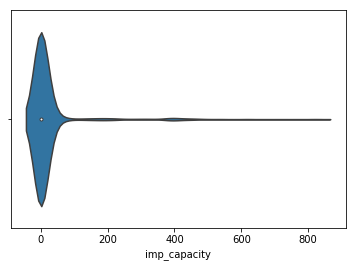

In [99]:
sns.violinplot(x=duration_improvement_capacity.toPandas()["imp_capacity"])

In [100]:
#duration_improvement_capacity.write.csv(path=base_folder_path+'/duration_improvement_capacity',header=True, mode='overwrite')

In [ ]:
#trips_actual_itineraries_filtered.write.csv(path=base_folder_path+'/trips_actual_itineraries',header=True, mode='overwrite')